# Import Library

In [1]:
import os
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import splitfolders

# Pengambilan Dataset

In [2]:
# base_dir = '\capstone\Dataset'
base_dir = r'D:\Unmul\Bangkit\Capstone\Model\Bangkit-main\Model 1\Dataset'

Split data

In [3]:
splitfolders.ratio(
    base_dir,
    output='fixDataset',
    ratio=(.7,0.1, 0.2)
)

Copying files: 1500 files [00:01, 755.99 files/s]


In [4]:
train_dir = 'fixDataset/train/'
val_dir = 'fixDataset/val/'
val_dir = 'fixDataset/test/'
os.listdir(train_dir)

['Angklung', 'Arumba', 'Calung', 'Jengglong', 'Kendang']

# Augmentasi Gambar

In [5]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=0.45,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    brightness_range=(0.5,1.0), 
                    shear_range=0.2, 
                    zoom_range=(0.8,1.0), 
                    fill_mode='nearest', 
                    horizontal_flip=True
                    )
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir, # direktori data train
    target_size=(150,150), # mengubah resolusi seluruh gambar jadi 150*150
    batch_size=32,# untuk menentukan jumlah image yang akan dimasukkan ke dalam steps training
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 1198 images belonging to 5 classes.
Found 304 images belonging to 5 classes.
Found 304 images belonging to 5 classes.


In [7]:
image, label = train_generator.next()

In [8]:
class_name = os.listdir(train_dir)

In [9]:
class_name

['Angklung', 'Arumba', 'Calung', 'Jengglong', 'Kendang']

# Transfer Learning

In [10]:
from keras.callbacks import EarlyStopping

monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=2)

In [11]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience= 2,
    verbose= 1,
    factor=0.3,
    min_lr=0.000001
)

In [12]:
from tensorflow.keras.applications import InceptionV3
model = InceptionV3(weights = 'imagenet',
                    include_top=False,
                    input_shape=(150,150,3))
model.trainable = False

In [13]:
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications

In [14]:
add_model = Sequential()
add_model.add(model)
add_model.add(Flatten())
add_model.add(tf.keras.layers.Dense(1024, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(5, activation='softmax'))

model = add_model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 1024)              18875392  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 40,683,301
Trainable params: 18,880,517
Non-trainable params: 21,802,784
_________________________________________________________________


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
history = model.fit(train_generator,
                    epochs=15,
                    shuffle=True,
                    verbose=True,
                    validation_data=val_generator,
                    callbacks=[reduce_lr,monitor_val_acc])

Epoch 1/15
38/38 [==============================] - 36s 833ms/step - loss: 0.9446 - accuracy: 0.8180 - val_loss: 0.0598 - val_accuracy: 0.9803 - lr: 1.0000e-04
Epoch 2/15
38/38 [==============================] - 28s 745ms/step - loss: 0.2840 - accuracy: 0.9382 - val_loss: 0.1237 - val_accuracy: 0.9638 - lr: 1.0000e-04
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9449
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
38/38 [==============================] - 27s 695ms/step - loss: 0.2205 - accuracy: 0.9449 - val_loss: 0.0423 - val_accuracy: 0.9803 - lr: 1.0000e-04


Lihat Hasil Evaluasi Accuracy dan Loss

In [16]:
test_loss, test_acc = model.evaluate(test_generator)
print("loss:", test_loss)
print("acc:", test_acc)

10/10 [==============================] - 5s 536ms/step - loss: 0.0423 - accuracy: 0.9803
loss: 0.04232776165008545
acc: 0.9802631735801697


Save Model

In [17]:
add_model.save('Model1.h5')

# Visualisasi

Akurasi Train & Validation

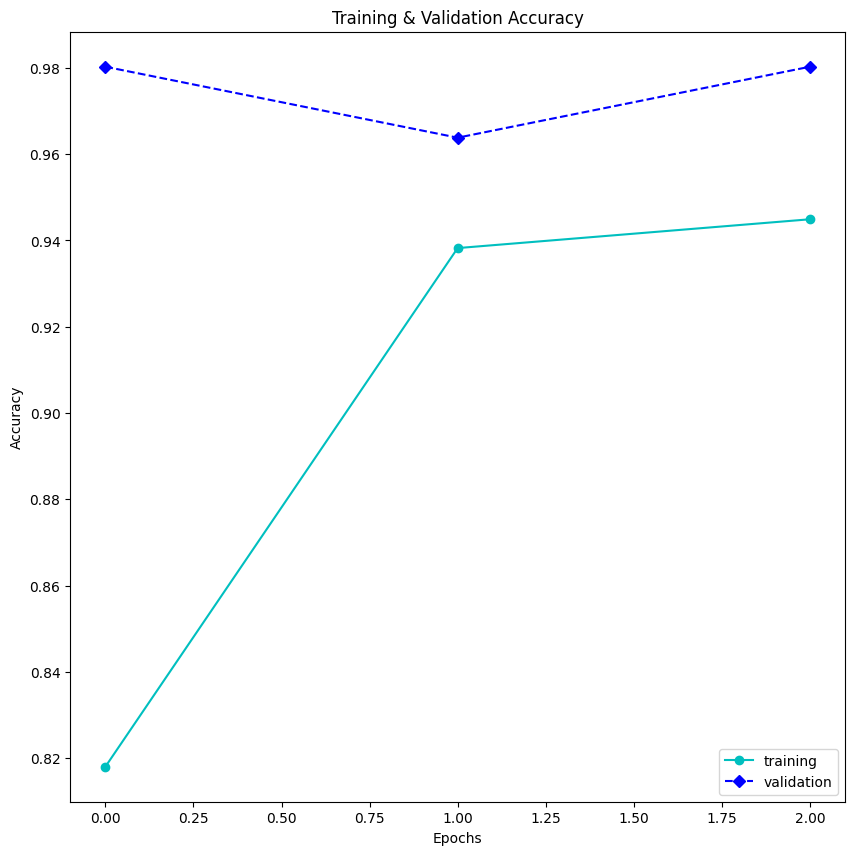

In [18]:
plt.figure(1, figsize=(10, 10))
plt.plot(range(len(history.history['accuracy'])),
         history.history['accuracy'],
         'co-',
         label='training')
plt.plot(
    range(len(history.history['val_accuracy'])),
    history.history['val_accuracy'],
    'bD--',
    label='validation'
)
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Visualisasi Loss Train & Val

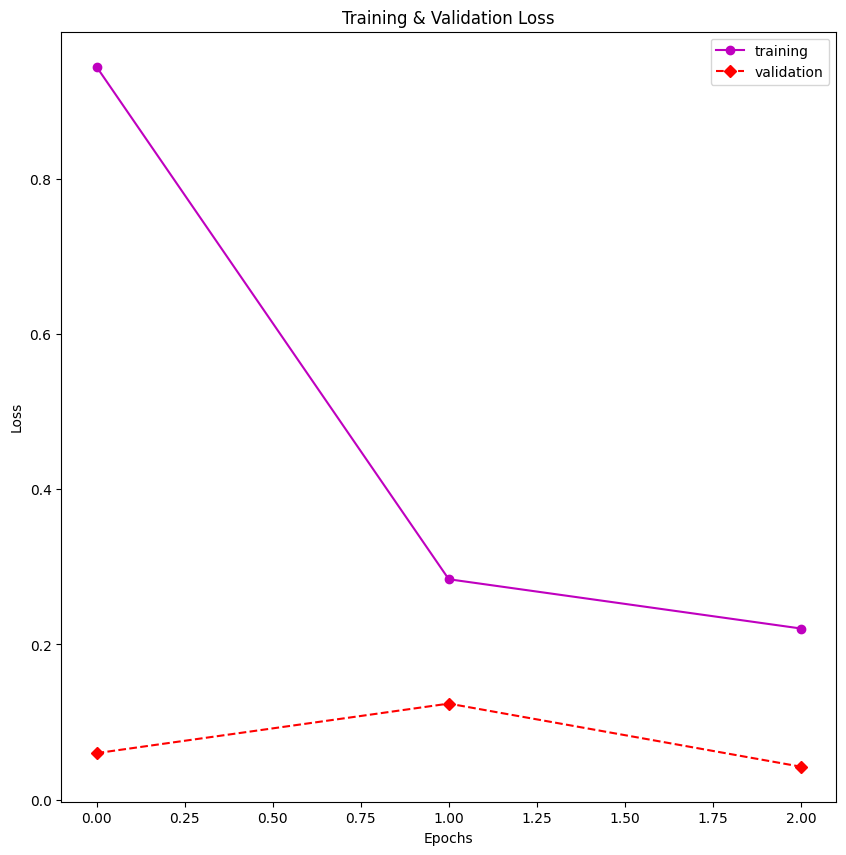

In [19]:
plt.figure(1, figsize=(10,10))
plt.plot(range(len(history.history['loss'])), 
         history.history['loss'],
         'mo-',
         label='training')
plt.plot(range(len(history.history['val_loss'])), 
         history.history['val_loss'],
         'rD--',
         label='validation')
plt.title('Training & Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Gambar berdasarkan Label

In [20]:
import numpy as np

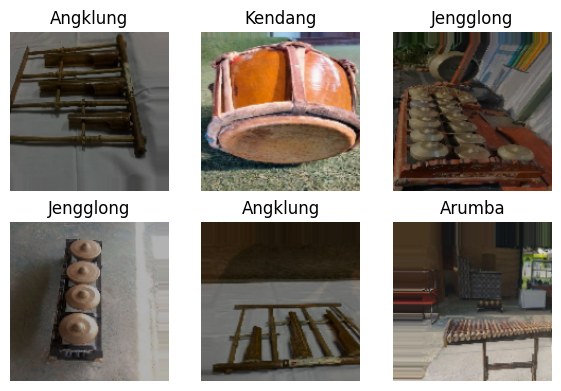

In [21]:
plt.figure(figsize=(7,7))
for i in range(6):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[i])
  plt.title(class_name[np.argmax(label[i])])
  plt.axis("off")

In [22]:
import tkinter as tk
from tkinter import filedialog
from keras.preprocessing import image
import numpy as np

root = tk.Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
filename = filedialog.askopenfilename()
%gui tk

img = tf.keras.utils.load_img(filename, target_size=(150, 150))
imgplot = plt.imshow(img)
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=32)

print(filename)
if classes[0][0] == 1:
  print('Angklung')
elif classes[0][1] == 1:
  print('Arumba')
elif classes[0][2] == 1:
  print('Calung')
elif classes[0][3] == 1:
  print('Jengglong')
else:
  print('Kendang')

FileNotFoundError: [Errno 2] No such file or directory: ''